In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.linalg import eigh
import pennylane as qml
from scipy.linalg import expm

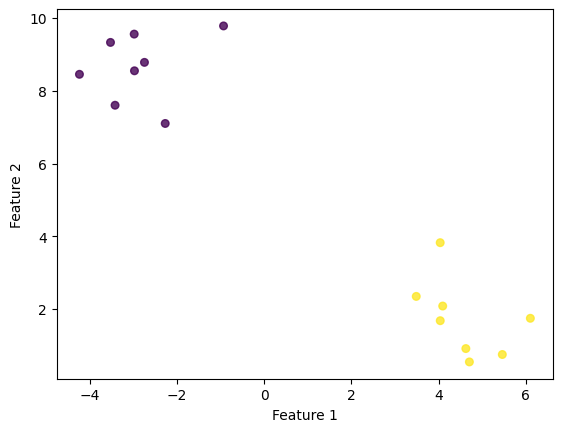

array([1.41729727e-06, 1.67331001e-06, 7.33920652e-04, 9.99999731e-01])

In [194]:
# data generation
X, Y = datasets.make_blobs(n_samples=16, centers=2, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=30, alpha=0.8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# matrices
A = np.exp(-pairwise_distances(X, metric='euclidean'))
D = np.diag(np.sum(A, axis=1))
L = D - A
L_inv = np.linalg.inv(L + np.eye(L.shape[0]) * 1e-6)
L_inv_norm = L_inv / np.linalg.norm(L_inv)
# L_inv_norm = np.linalg.matrix_power(L_inv_norm, 5)

# eigendecomposition for reference
inv_val, inv_vec = eigh(L_inv_norm)
inv_val[-4:]

0.9999997306758388


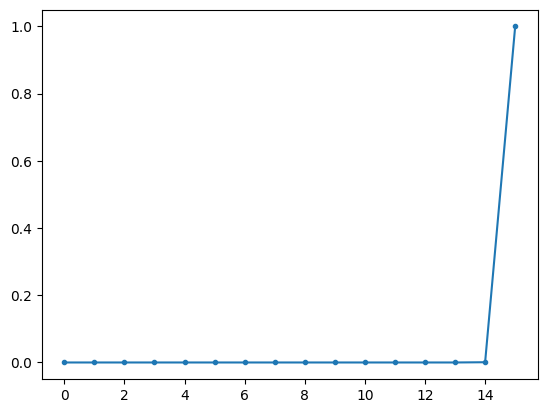

In [195]:
print(inv_val[-1])
plt.plot(inv_val,'.-')
plt.show()

In [196]:
# check if a matrix is Hermitian
def check_hermitain(A):
    return np.allclose(A, A.conj().T)

def check_unitary(A):
    I = np.eye(A.shape[0])
    return np.allclose(A.conj().T @ A, I) and np.allclose(A @ A.conj().T, I)

print("hermitian : ", check_hermitain(L), check_hermitain(L_inv), check_hermitain(L_inv_norm))
print("unitary : ", check_unitary(L), check_unitary(L_inv), check_unitary(L_inv_norm))
print("unitary : ", check_unitary(expm(-1j*L)), check_unitary(expm(-1j*L_inv)), check_unitary(expm(-1j*L_inv_norm)))

hermitian :  True True True
unitary :  False False False
unitary :  True True True


In [197]:
# quantum power method based on the blaock encoding
L_dec = qml.pauli_decompose(L_inv_norm)
coeff, op = L_dec.terms()
print(len(L_dec))

128


In [198]:
dev = qml.device("default.qubit", wires=14) 
reg = qml.registers({"control": 7, "target": 7}) 
norm_coeff = (np.sqrt(coeff) / np.linalg.norm(np.sqrt(coeff)))
# scaling_factor = sum(abs(norm_coeff))

# shifing wires for unitaries
unitaries = [qml.map_wires(op_elem, {i: i + 7 for i in range(7)}) for op_elem in op]

def block_encoding():
    qml.StatePrep(norm_coeff, wires=reg['control'])
    qml.Select(unitaries, control=reg['control'])
    qml.adjoint(qml.StatePrep(norm_coeff, wires=reg['control']))

@qml.qnode(dev)
def power_method():
    # for i in reg['target']:
    #     qml.Hadamard(i)
    block_encoding()
    return qml.state() # qml.expval(qml.Hermitian(L_inv_norm, wires=reg['target']))

# qml.draw_mpl(power_method, style='pennylane')()
# plt.show()

C:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\pennylane\numpy\tensor.py:152: RuntimeWarning: invalid value encountered in sqrt
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


In [185]:
output_matrix = qml.matrix(power_method)()
print("L_inv_norm:\n", pd.DataFrame(L_inv_norm), "\n")

submatrix = output_matrix[:16, :16]
print("Block-encoded L_inv_norm:\n")
print(pd.DataFrame(np.real(np.round(submatrix,3)))) # 

L_inv_norm:
         0       1       2       3       4       5       6       7       8   \
0   0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625   
1   0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625   
2   0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625   
3   0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625   
4   0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625   
5   0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625   
6   0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625   
7   0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625   
8   0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625   
9   0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625   
10  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625   
11  0.0625  0.0625  0.0625  0.0625  0.0625  0.0625 

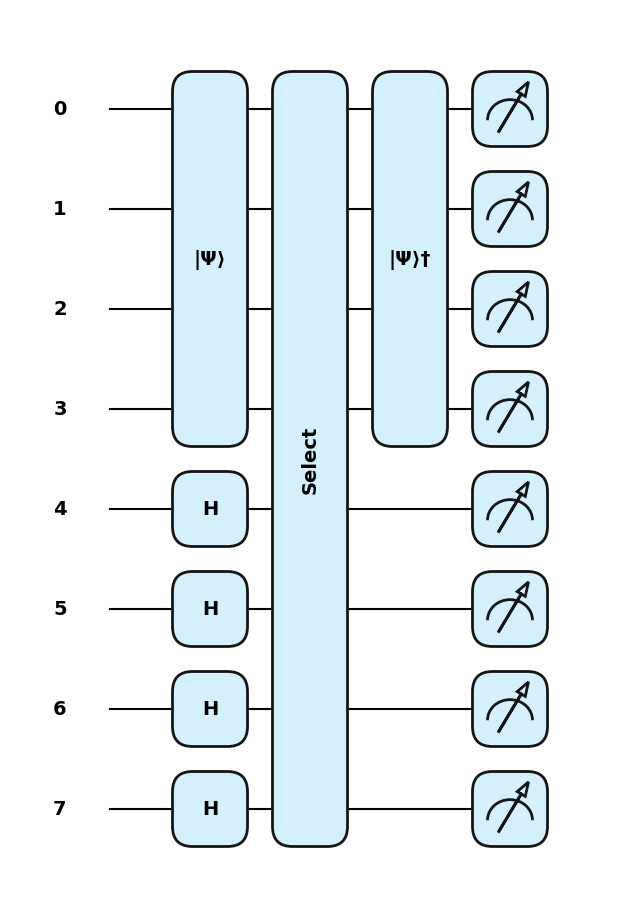

In [186]:
dev = qml.device("default.qubit", wires=8) 
reg = qml.registers({"control": 4, "target": 4}) 
norm_coeff = (np.sqrt(coeff) / np.linalg.norm(np.sqrt(coeff)))
# scaling_factor = sum(abs(norm_coeff))

# shifing wires for unitaries
unitaries = [qml.map_wires(op_elem, {i: i + 4 for i in range(4)}) for op_elem in op]

def block_encoding():
    qml.StatePrep(norm_coeff, wires=reg['control'])
    qml.Select(unitaries, control=reg['control'])
    qml.adjoint(qml.StatePrep(norm_coeff, wires=reg['control']))

@qml.qnode(dev)
def power_method():
    for i in reg['target']:
        qml.Hadamard(i)
    block_encoding()
    return qml.state() # qml.expval(qml.Hermitian(L_inv_norm, wires=reg['target']))

qml.draw_mpl(power_method, style='pennylane')()
plt.show()

In [187]:
# post-processing
def select_indices_multi(n_qubits, measured_wires, outcomes):
    return [
        i for i in range(2 ** n_qubits)
        if all(format(i, f'0{n_qubits}b')[wire] == str(outcome) 
               for wire, outcome in zip(measured_wires, outcomes))
    ]
    
state = power_method()
indices = select_indices_multi(n_qubits=8, measured_wires=[0, 1, 2, 3], outcomes=[0,0,0,0])
projected = np.array([state[i] for i in indices])
print(len(np.real(projected)), np.real(projected))
post_selected = projected / np.linalg.norm(projected)
print(np.real(post_selected)) # get the constant vector - correct!

16 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25]
[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25]


In [188]:
# expectation value?
@qml.qnode(dev)
def power_method():
    for i in reg['target']:
        qml.Hadamard(i)
    block_encoding()
    return qml.expval(qml.Hermitian(L_inv_norm, wires=reg['target']))

d_eig = math.pow(power_method(),1/3)
d_eig # correct

0.999999551126434

In [189]:
@qml.qnode(dev)
def pm(L_inv_norm):
    for i in reg['target']:
        qml.Hadamard(i)
    block_encoding()
    return qml.expval(qml.Hermitian(L_inv_norm, wires=reg['target'])), qml.state()

def select_indices_multi(n_qubits, measured_wires, outcomes):
    return [
        i for i in range(2 ** n_qubits)
        if all(format(i, f'0{n_qubits}b')[wire] == str(outcome) 
               for wire, outcome in zip(measured_wires, outcomes))]
    
val, vec = pm(L_inv_norm)
def post_pm(val, vec):
    indices = select_indices_multi(n_qubits=8, measured_wires=[0, 1, 2, 3], outcomes=[0,0,0,0])
    projected = np.array([state[i] for i in indices])
    post_selected = projected / np.linalg.norm(projected)
    return math.pow(val, 1/3), post_selected

val, vec = post_pm(val,vec)

In [193]:
def deflate(A, eig_val, eig_vec):
    return A - eig_val * np.outer(eig_vec, eig_vec)

def block_encoding():
    qml.StatePrep(norm_coeff, wires=reg['control'])
    qml.Select(unitaries, control=reg['control'])
    qml.adjoint(qml.StatePrep(norm_coeff, wires=reg['control']))
    
def power_method(A):
    A_dec = qml.pauli_decompose(A)
    coeff, op = A_dec.terms()
    n_half = int(len(L_dec)/2)
    
    dev = qml.device("default.qubit", wires=n_half*2) 
    reg = qml.registers({"control": n_half, "target": n_half}) 
    norm_coeff = (np.sqrt(coeff) / np.linalg.norm(np.sqrt(coeff)))
    
    # shifing wires for unitaries
    unitaries = [qml.map_wires(op_elem, {i: i + n_half for i in range(n_half)}) for op_elem in op]

    val, vec = pm(A)
    val, vec = post_pm(val,vec)
    return val, vec
    
# power and deflation methods
def_val = []
def_vec = []
def_mat = L_inv_norm

eig_val, eig_vec = power_method(def_mat)
def_val.append(eig_val)
def_vec.append(eig_vec)
def_mat = deflate(def_mat, eig_val, eig_vec)
def_mat.shape

pd.DataFrame(np.real(np.round(def_mat,5)))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
5,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
6,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
7,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
8,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
9,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
